#### __18. 강화학습__

In [1]:
import os
import sys
 
import sklearn
import tensorflow as tf

import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

__18.3 OpenAI 짐__

In [2]:
import gym

In [107]:
# 카트 위에 놓은 막대가 넘어지지 않도록 왼쪽이나 오른쪽으로 가속할 수 있는 2D 시뮬레이션
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs = env.reset()  # 환경을 만든 후 초기화, 첫 번째 관측 반환
obs  # 카트의 수평 위치, 카트의 속도, 막대의 각도, 막대의 각속도(양수는 시계 방향)

(array([ 0.04144956, -0.01043923, -0.03545364,  0.01702134], dtype=float32),
 {})

In [68]:
env.render()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [69]:
img = env.render()
img.shape

(400, 600, 3)

In [70]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

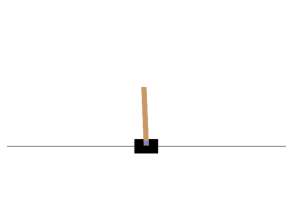

In [71]:
plot_environment(env)
plt.show()

In [72]:
env.action_space  # 가능한 행동이 정수 0과 1(각각 왼쪽 가속과 오른쪽 가속)

Discrete(2)

In [75]:
action = 0
obs, reward, done, some_bool, info = env.step(action)
obs

array([-0.00777738, -0.35190392, -0.03158057,  0.5615649 ], dtype=float32)

In [76]:
reward

1.0

In [77]:
done

False

In [78]:
info

{}

In [80]:
if done:
    obs = env.reset()

In [98]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs = env.reset()

In [112]:
# 간단한 정책 하드코딩
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    obs = obs[0]  # 오류 수정을 위해 index 삽입
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, some_bool, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [113]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.138, 8.744309921314546, 24.0, 68.0)

In [123]:
# 에피소드 시각화
frames = []

obs = env.reset()
obs = obs[0]
for step in range(200):
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, some_bool, info = env.step(action)
    if done:
        break

In [12]:
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [125]:
plot_animation(frames)

__18.4 신경망 정책__

In [3]:
n_inputs = 4  # 관측 공간의 크기

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs = env.reset()
    obs = obs[0]
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, some_bool, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [21]:
frames = render_policy_net(model)
plot_animation(frames)

1/1 [==============================] - 0s 17ms/step


In [ ]:
# 코드 수정 필요
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
np.random.seed(42)
observations = [env.reset() for env in envs]
observations = [obs[0] for obs in observations]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy


for iteration in range(n_iterations):
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, some_bool, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

__18.6 정책 그레이디언트__

In [42]:
# REINFORCE 알고리즘
'''
1. 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그레이디언트 계산
2. 에피소드를 몇 번 실행한 후, 각 행동의 이익을 계산(신용 할당 문제, 할인 계수)
3. 행동의 이익이 양수이면 미래에 선택될 가능성이 높도록 앞서 계산한 그레이디언트 적용, 음수이면 그 반대로 적용
4. 모든 결과 그레이디언트 벡터를 평균 내어 경사 하강법 스텝 수행
'''
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [43]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [44]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [45]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [46]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [47]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [49]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [50]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [ ]:
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

__18.7 마르코프 결정 과정(MDP)__

In [65]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 50

def print_sequence():
    current_state = 0
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


In [70]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [71]:
Q_values = np.full((3, 3), -np.inf)  # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해서

Q_values

array([[  0.,   0.,   0.],
       [  0., -inf,   0.],
       [-inf,   0., -inf]])

In [72]:
gamma = 0.90  # 할인 계수

history1 = []
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1)

In [73]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [76]:
np.argmax(Q_values, axis=1)

array([0, 0, 1], dtype=int64)